In [1]:
import geopandas as gpd
import pandas as pd
import eecisc
import seaborn
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 7)

In [2]:
SOURCE_PATH = "/notebooks/sjoin_selection_arcgis.shp"
PROCESSED_PATH = "/notebooks/processed.shp"
ADJACENCY_PATH = "/notebooks/adjacency.csv"

In [3]:
source = eecisc.read_shapefile(SOURCE_PATH)
processed = eecisc.read_shapefile(PROCESSED_PATH)
adjacency = pd.read_csv(eecisc.read_file(ADJACENCY_PATH))

User name on eecisc: mmxc2
Password: ········
User name on eecisc: mmxc2
Password: ········
User name on eecisc: mmxc2
Password: ········


In [4]:
source_only_buildings = source[source.FTC == 1].copy()
source_only_buildings.sort_values(by='GTN', inplace=True)
source_only_buildings.reset_index(inplace=True)

In [5]:
assert source_only_buildings.index.size == processed.index.size
assert (source_only_buildings.GTN == processed.GTN).all()
assert source_only_buildings.geometry.intersects(processed.geometry).all()
assert source_only_buildings.index.size == processed.index.size
assert (source_only_buildings.GTN == processed.GTN).all()
assert source_only_buildings.geometry.intersects(processed.geometry).all()

# Tests on Randomly Selected Buildings

In [6]:
#First, we confine our test buildings to only those changed by either Geopandas or ArcGIS
def compare(tolerance):
    GP_tol = tolerance       #Set the tolerance for simplify
    Arc_change_mask = source_only_buildings.geometry != processed.geometry
    GP_change_mask = source_only_buildings.geometry != source_only_buildings.simplify(GP_tol).geometry
    Both_change_mask = [x and y for x, y in zip(Arc_change_mask, GP_change_mask)]
    Different_change_mask = source_only_buildings[Both_change_mask].simplify(GP_tol).geometry != processed[Both_change_mask].geometry

    building_data ={'ArcGIS': Arc_change_mask,                #Returns True if ArcGIS changes source buildings
                   'Geopandas': GP_change_mask,                #Returns True if GP Simplify changes source buildings
                   'Both': Both_change_mask,                  #Returns True if both GP and ArcGIS made changes to same building
                   'Different change': Different_change_mask}  #Returns True if the changes by GP and ArcGIS are different

    building_df = pd.DataFrame(building_data, columns = ['ArcGIS', 'Geopandas', 'Both', 'Different change'])
    return building_df

In [7]:
tolerance = 0.4

changed_buildings_mask = [x or y for x,y in zip(compare(tolerance)['ArcGIS'], compare(tolerance)['Geopandas'])]

changed_buildings = [i for i,j in enumerate(changed_buildings_mask) if j==True]

In [33]:
#Random selection of buildings. 
# I've chosen the random seed to be today's date, 04/08/16.

import random
random.seed(40816)

random_building = []
for x in range(12):
    num = random.choice(changed_buildings)
    random_building.append(num)

In [34]:
random_building.sort()

In [44]:
random_building

[12, 65, 69, 104, 119, 127, 128, 144, 162, 192, 217, 323]

In [36]:
def plot_building(number):
    building = source_only_buildings.ix[number].geometry
    building_processed = processed.ix[number].geometry
    building_simplified = source_only_buildings.ix[number].geometry.simplify(tolerance)
    ax=gpd.GeoSeries([building]).plot(label='original', figsize=(7, 9))
    gpd.GeoSeries([building_processed]).plot(ax=ax, linestyle='--', label='ArcGIS')
    gpd.GeoSeries([building_simplified]).plot(ax=ax, linestyle='-.', label='Shapely')
    plt.title('Building #%d'%number)
    legend = plt.legend()

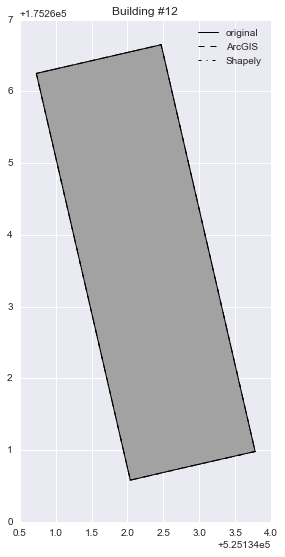

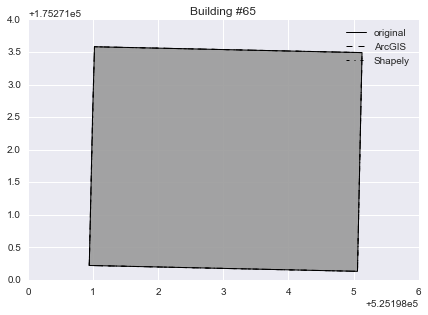

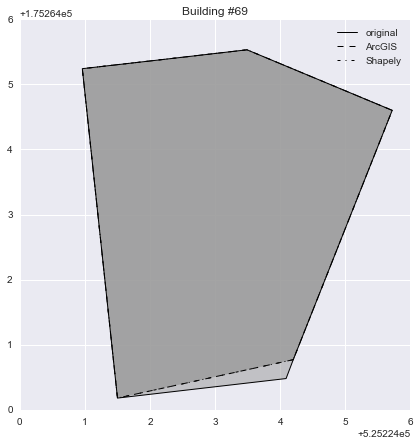

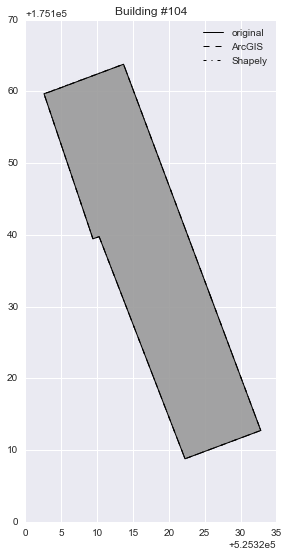

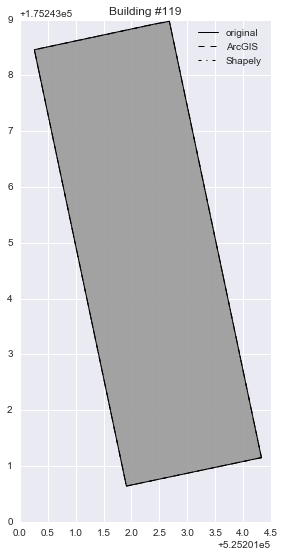

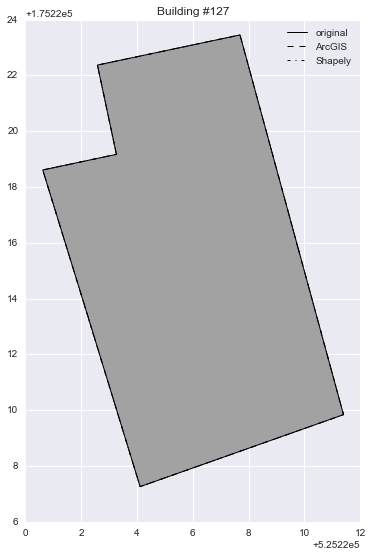

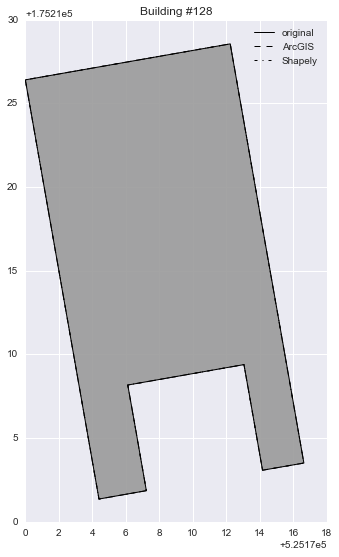

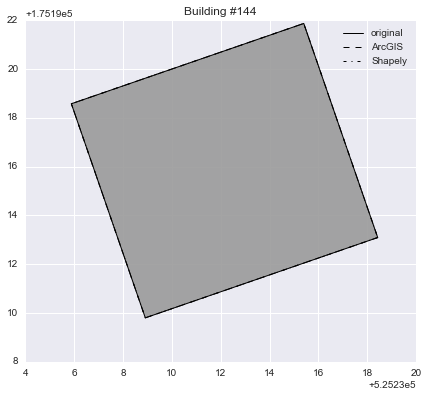

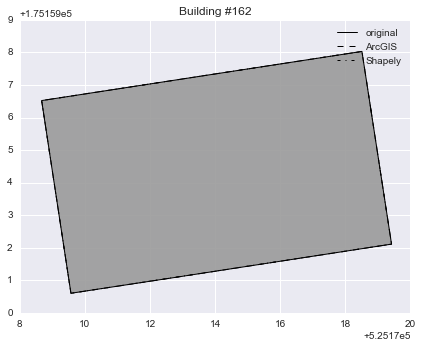

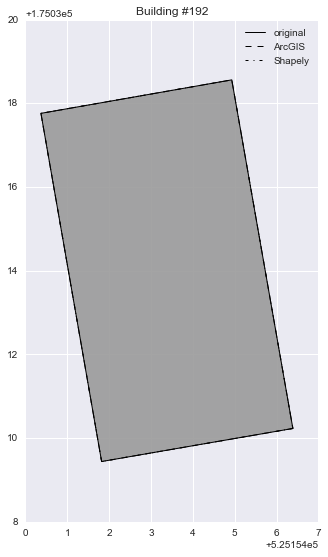

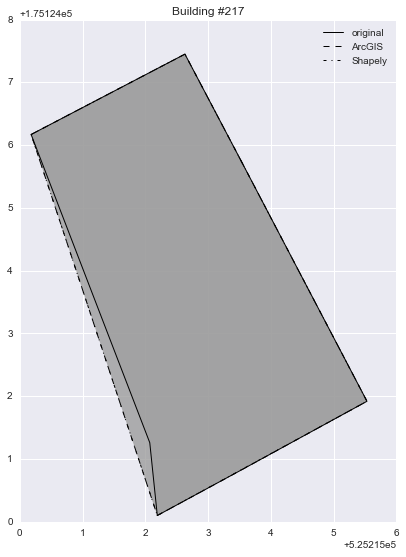

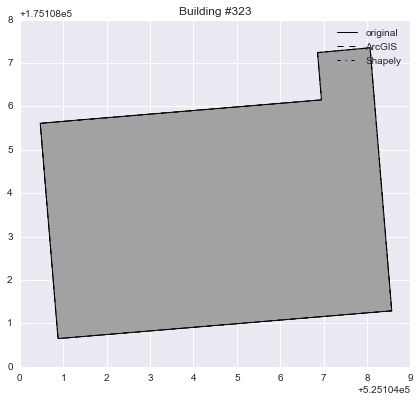

In [37]:
for i in random_building:
    plot_building(i)

Of the 10 buildings I picked, 8 of the buildings had visually non-differentiatable changes. 

In [39]:
from collections import OrderedDict
def compare_values(number, dataframe=pd.DataFrame(index=[], columns = []), answer=None):
    
    a = source_only_buildings.area[number]
    b = source_only_buildings.simplify(tolerance).area[number]
    c = processed.area[number]
    d = source_only_buildings.geometry.map(lambda x: len(x.exterior.coords))[number]
    e = source_only_buildings.simplify(tolerance).geometry.map(lambda x: len(x.exterior.coords))[number]
    f = processed.geometry.map(lambda x: len(x.exterior.coords))[number]
    para = [a,b,c,d,e,f]
    
    values = OrderedDict()
    values['Raw Area'] = a
    values['GP Area'] = b
    values['ArcGIS Area'] = c
    values['Raw Vertices'] = int(d)
    values['GP Vertices'] = int(e)
    values['ArcGIS Vertices'] = int(f)
    
    if type(dataframe) is not pd.DataFrame:
        dataframe =pd.DataFrame(index=[], columns = [])
        #print('Something')
    
    if dataframe.empty:
        dataframe = pd.DataFrame(values, columns = [i for i in values], index = [number])
        return dataframe
    
    elif len(dataframe.columns)!=len(para):
        print('Invalid empty dataframe. Replaced with new dataframe')
        dataframe = pd.DataFrame(values, columns = [i for i in values], index = [number])
        return dataframe
    
    elif len(dataframe.index)!=0:
        if answer==None:
            answer = input('Replace data?[y/n]')
        while answer != 'y' or answer != 'n':
            if answer == 'y':
                dataframe = pd.DataFrame(values, columns = [i for i in values], index = [number])
                return dataframe
            elif answer == 'n':
                dataframe.loc[number] = para
                return dataframe
            else:
                answer=input('Invalid input. Replace data?[y/n]')
    
    else:
        dataframe.loc[number] = para
        return dataframe
    

In [45]:
compare_test_buildings = []
for number in random_building:
    compare_test_buildings = compare_values(number, compare_test_buildings, answer='n')

In [47]:
compare_test_buildings

,Raw Area,GP Area,ArcGIS Area,Raw Vertices,GP Vertices,ArcGIS Vertices
12,10.38720,10.38980,10.38720,6.0,5.0,6.0
65,13.83995,13.83315,13.83995,6.0,5.0,6.0
69,18.44970,18.09190,18.09065,8.0,6.0,7.0
104,639.70155,639.96800,639.70155,11.0,8.0,11.0
119,19.77425,19.76590,19.77425,6.0,5.0,6.0
127,107.05875,107.09100,107.05875,9.0,8.0,9.0
128,270.79555,270.73565,270.73565,15.0,10.0,12.0
144,93.45630,93.45910,93.45630,6.0,5.0,6.0
162,59.66750,59.64965,59.66750,7.0,6.0,7.0
192,39.15905,39.16035,39.15905,6.0,5.0,6.0


In [ ]:
type(df1)

In [ ]:
df3 = pd.DataFrame(2, index=[1], columns = [1,2,3,4,5,6])

In [ ]:
df3

In [ ]:
dfff2 = compare_values(33, df3)

In [ ]:
dfff2

In [48]:
type(source_only_buildings)

geopandas.geodataframe.GeoDataFrame

In [50]:
source=source_only_buildings

In [51]:
source

,index,ADF10,ADF11,ADF12,ADF13,ADF14,ADF15,ADF16,ADF17,ADF18,...,TRANS_TER,TRANS_WAY,UCC,UNIVERSITY,UNUSED,WAREHOUSE,WATER,ZONECODE,ZONECODE_1,geometry
0,0,None,None,None,None,None,None,None,None,0,...,0.0,0.0,0.0,0.0,32.0,0.0,943340.872200,E02000932,E01004603,"POLYGON ((525364.1100000003 175268.3300000001,..."
1,3,None,None,None,None,None,None,None,None,0,...,0.0,0.0,0.0,0.0,32.0,0.0,943340.872200,E02000932,E01004603,"POLYGON ((525094 175244.1600000002, 525089.889..."
2,4,POINT PLEASANT,None,None,None,LONDON,ENGLAND,None,None,0,...,0.0,0.0,0.0,0.0,32.0,0.0,943340.872200,E02000932,E01004603,"POLYGON ((525148.3600000003 175242.6799999997,..."
3,5,None,None,None,None,None,None,None,None,0,...,0.0,0.0,0.0,0.0,32.0,0.0,943340.872200,E02000932,E01004603,"POLYGON ((525233.5499999998 175236.8100000005,..."
4,9,None,None,None,None,None,None,None,None,0,...,0.0,0.0,0.0,0.0,32.0,0.0,943340.872200,E02000932,E01004603,"POLYGON ((525085.6500000004 175290.0099999998,..."
5,21,None,None,None,None,None,None,None,None,0,...,0.0,0.0,0.0,0.0,32.0,0.0,943340.872200,E02000932,E01004603,"POLYGON ((525316.9100000002 175270.2899999991,..."
6,23,None,None,None,None,None,None,None,None,0,...,0.0,0.0,0.0,0.0,32.0,0.0,943340.872200,E02000932,E01004603,"POLYGON ((525209.3399999999 175269.8900000006,..."
7,24,None,None,None,None,None,None,None,None,0,...,0.0,0.0,0.0,0.0,32.0,0.0,943340.872200,E02000932,E01004603,"POLYGON ((525289.7400000002 175095.9199999999,..."
8,8,NORTHFIELDS,None,None,None,LONDON,ENGLAND,None,ALL,0,...,0.0,0.0,0.0,0.0,32.0,0.0,943340.872200,E02000932,E01004603,"POLYGON ((525117.3300000001 175286, 525116.950..."
9,13,None,None,None,None,None,None,None,None,0,...,0.0,0.0,0.0,0.0,32.0,0.0,943340.872200,E02000932,E01004603,"POLYGON ((525314.9299999997 175280.1899999995,..."
